# Full prediction pipeline using YOLOv3 and Google Vision API

In [1]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0, "../scripts")
from prediction_utils import *

In [2]:
# add Cloud Vision API key to environment
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../ServiceAccountToken_VisionAPI.json'

In [3]:
src_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "2_Training", "src")
utils_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "Utils")

sys.path.append(src_path)
sys.path.append(utils_path)

# more imports here
from keras_yolo3.yolo import YOLO
from utils import detect_object

# Set up folder names for default values
data_folder = os.path.join('..','YOLOv3','TrainYourOwnYOLO', "Data")
image_folder = os.path.join(data_folder, "Source_Images")
image_test_folder = os.path.join(image_folder, "Test_Images")
model_folder = os.path.join(data_folder, "Model_Weights")
model_weights = os.path.join(model_folder, "trained_weights_final_ck2000.h5")
model_classes = os.path.join(model_folder, "data_classes.txt")
anchors_path = os.path.join(src_path, "keras_yolo3", "model_data", "yolo_anchors.txt")

# define YOLO detector
yolo = YOLO(
    **{
        "model_path": model_weights,
        "anchors_path": anchors_path,
        "classes_path": model_classes,
        "score": 0.25,
        "gpu_num": 1,
        "model_image_size": (416, 416),
    }
)

Using TensorFlow backend.
W0611 12:57:34.082668 140237775898368 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0611 12:57:34.083727 140237775898368 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0611 12:57:34.085017 140237775898368 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0611 12:57:34.102042 140237775898368 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/ba

../YOLOv3/TrainYourOwnYOLO/Data/Model_Weights/trained_weights_final_ck2000.h5 model, anchors, and classes loaded in 10.93sec.


W0611 12:57:45.267571 140237775898368 deprecation.py:323] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/tensorflow_core/python/ops/array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [45]:
# Get cereal info from DB
conn =  connect_to_db()
s = 'select * from cereals'
df = pd.read_sql(s, connect_to_db())

# Load image
img_fname = os.path.join('..', 'data', 'real_box_shelves', 'Walgreens-cereal-4.jpg')
img = Image.open(img_fname).convert("RGB")
new_img = copy.deepcopy(img)

# Run YOLO detector
YOLO_predictions, new_image = yolo.detect_image(new_img);

# Generate vertically-stacked image 
stacked_image, stacked_img_edges = generate_stacked_image(YOLO_predictions, img)

# Detect text with Cloud Vision API and parse results
OCR_words_all, OCR_vertices = Vision_API_OCR(stacked_image)
    
#for word, vertices in zip(OCR_words_all, OCR_vertices):
#    print(word, vertices)

(416, 416, 3)
Found 20 boxes for img
cereal_box 0.97 (660, 1) (752, 83)
cereal_box 0.98 (13, 0) (107, 92)
cereal_box 0.99 (305, 3) (396, 100)
cereal_box 1.00 (211, 292) (288, 407)
cereal_box 1.00 (641, 298) (738, 392)
cereal_box 1.00 (107, 2) (206, 91)
cereal_box 1.00 (453, 146) (558, 272)
cereal_box 1.00 (25, 299) (123, 411)
cereal_box 1.00 (706, 171) (755, 281)
cereal_box 1.00 (211, 3) (305, 98)
cereal_box 1.00 (368, 297) (443, 401)
cereal_box 1.00 (166, 138) (280, 278)
cereal_box 1.00 (621, 153) (703, 274)
cereal_box 1.00 (122, 309) (206, 409)
cereal_box 1.00 (445, 299) (517, 399)
cereal_box 1.00 (67, 133) (168, 278)
cereal_box 1.00 (399, 5) (490, 104)
cereal_box 1.00 (0, 122) (71, 278)
cereal_box 1.00 (369, 148) (451, 272)
cereal_box 1.00 (290, 295) (367, 408)
Time spent: 0.506sec


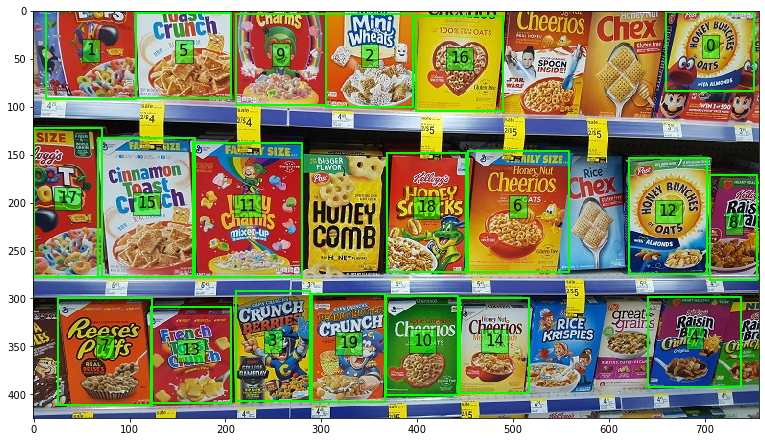

In [46]:
fig, ax = plt.subplots(1, figsize=(13,10))
ax.imshow(img);
for ix, box in enumerate(YOLO_predictions):
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=2, color='lime')
    ax.text(np.mean([box[0], box[2]]), np.mean([box[1],box[3]]), str(ix), fontsize=15, bbox=dict(facecolor='lime', alpha=0.5), horizontalalignment='center')

In [47]:
# loop through detected boxes
prediction_results = []
for ix, box in enumerate(YOLO_predictions):
    # Find OCR text in this cereal box
    OCR_words = set()
    for word, vertices in zip(OCR_words_all, OCR_vertices):
        if (vertices['y'] > stacked_img_edges[ix]).all() & (vertices['y'] < stacked_img_edges[ix+1]).all():
            OCR_words.add(word)
    if len(OCR_words) > 0:
        # predict cereal
        label = get_cereal(df, OCR_words)
        # compile results in dictionary
        prediction_results.append({
            'OCR': OCR_words,
            'box': box[0:4],
            'label': label
        })
prediction_results

[{'OCR': {'bunce', 'c', 'oats', 'oney'},
  'box': [660, 1, 752, 83],
  'label': 'Honey Bunches of Oats'},
 {'OCR': {'wheas'}, 'box': [305, 3, 396, 100], 'label': ''},
 {'OCR': {'crunch', 'rerries'},
  'box': [211, 292, 288, 407],
  'label': "Cap'n Crunch"},
 {'OCR': {'raisin'}, 'box': [641, 298, 738, 392], 'label': 'Raisin Bran'},
 {'OCR': {'crunch'}, 'box': [107, 2, 206, 91], 'label': "Cap'n Crunch"},
 {'OCR': {'cheerios', 'honey,', 'ily', 'nut', 'oats', 'size'},
  'box': [453, 146, 558, 272],
  'label': 'Honey Nut Cheerios'},
 {'OCR': {'puffs', "reese's"},
  'box': [25, 299, 123, 411],
  'label': 'Cocoa Puffs'},
 {'OCR': {'cheerios', 'l.', 'oats', 'u'},
  'box': [368, 297, 443, 401],
  'label': 'Cheerios'},
 {'OCR': {'*', 'a', 'charms', 'e', 'fa', 'lucky', 'mixeb-up', 'size'},
  'box': [166, 138, 280, 278],
  'label': 'Lucky Charms'},
 {'OCR': {'*oats', 'almonds', 'gunche'},
  'box': [621, 153, 703, 274],
  'label': ''},
 {'OCR': {'french', 'ocrunch', 'toast'},
  'box': [122, 309, 20

In [94]:
allergies = ['wheat', 'soy', 'sesame']

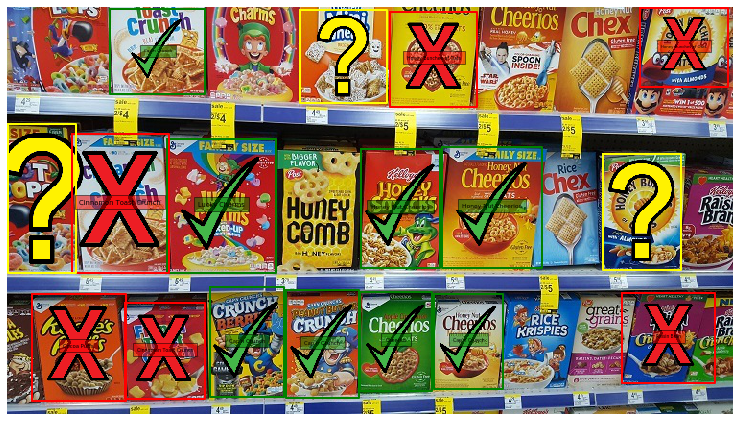

In [96]:
temp_img = copy.deepcopy(img)

symbol_dir = os.path.join('..', 'Flask', 'static', 'img')
question_symbol = Image.open(os.path.join(symbol_dir, 'question_symbol.png'))
check_symbol = Image.open(os.path.join(symbol_dir, 'check_symbol.png'))
x_symbol = Image.open(os.path.join(symbol_dir, 'x_symbol.png'))

# Plot bonding boxes and annotations
box_color = []
for result in prediction_results:
    box = result['box']
    label = result['label']
    fontsize = (box[3]-box[1]) / img.size[1]

    # if no allergies selected, all are safe
    if len(allergies) == 0:
        symbol = copy.deepcopy(check_symbol)
        box_color.append('green')
    else:
        # if cereal type is unknown
        if label == '':
            symbol = copy.deepcopy(question_symbol)
            box_color.append('yellow')
        else:
            # if dangerous
            if df[df.cereal_name==label][allergies].sum().sum() > 0:
                symbol = copy.deepcopy(x_symbol)
                box_color.append('red')
            else:
                # if unknown
                if df[df.cereal_name==label][allergies].isnull().values.any():
                    symbol = copy.deepcopy(question_symbol)
                    box_color.append('yellow')
                # if safe
                else:
                    symbol = copy.deepcopy(check_symbol)
                    box_color.append('green')

    # resize symbol
    symbol_scale = 0.9
    new_height = int(np.round(box[3]-box[1]) * symbol_scale)
    new_width = int(np.round(new_height * symbol.size[0] / symbol.size[1]) * symbol_scale)
    symbol = symbol.resize((new_width, new_height))
    
    # figure out where to paste the symbol
    x_paste = int(np.mean([box[0],box[2]])-(new_width/2))
    y_paste = int(np.mean([box[1], box[3]])-(new_height/2))
    
    # paste    
    temp_img.paste(symbol, (x_paste,y_paste), symbol)


fig, ax = plt.subplots(1, figsize=(13,15))
ax.imshow(temp_img)
ax.set_axis_off()
    
# Plot bonding boxes and annotations
for result, color in zip(prediction_results, box_color):
    box = result['box']
    label = result['label']
    fontsize = (box[3]-box[1]) / img.size[1]

    # plot boxes
    ax.plot([box[0],box[2], box[2],box[0],box[0]],
        [box[1],box[1],box[3],box[3],box[1]],
        linewidth=2, color=color)
    # plot labels
    ax.text(np.mean([box[0], box[2]]),
        np.mean([box[1],box[3]]),
        str(label),
        fontsize=fontsize*20,
        bbox=dict(facecolor=color, alpha=0.5),
        horizontalalignment='center')

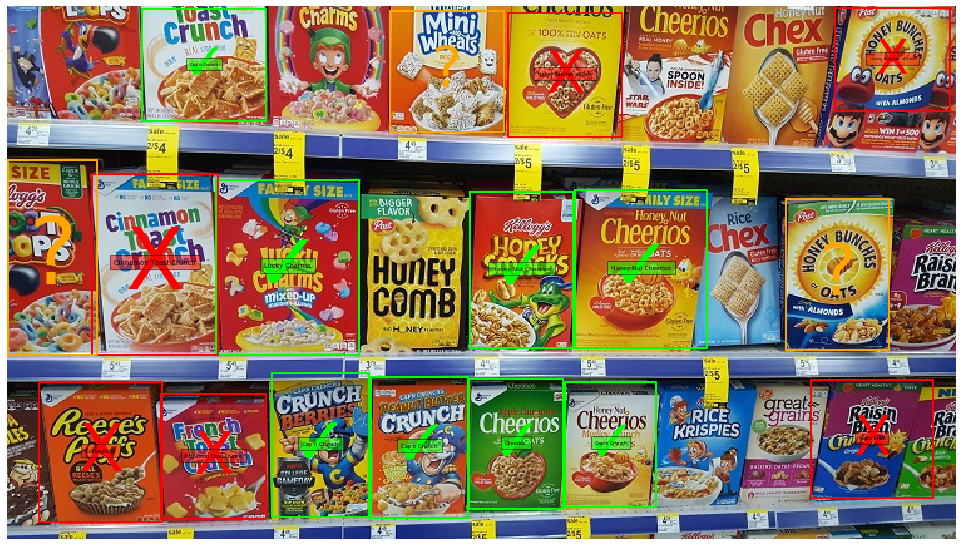

In [50]:
fig, ax = plt.subplots(1, figsize=(17,15))

ax.imshow(img)
ax.set_axis_off()

# Plot bonding boxes and annotations
for result in prediction_results:
    box = result['box']
    label = result['label']
    fontsize = (box[3]-box[1]) / img.size[1]

    # if cereal type is unknown
    if label == '':
        color = 'orange'
        symbol = '?'
    else:
        # if dangerous
        if df[df.cereal_name==label][allergies].sum().sum() > 0:
            color = 'red'
            symbol = 'X'
        else:
            # if unknown
            if df[df.cereal_name==label][allergies].isnull().values.any():
                color = 'orange'
                symbol = '?'
            # if safe
            else:
                color = 'lime'
                symbol = u'\u2713'



    # plot boxes
    ax.plot([box[0],box[2], box[2],box[0],box[0]],
        [box[1],box[1],box[3],box[3],box[1]],
        linewidth=2, color=color)
    # plot symbol
    ax.text(np.mean([box[0], box[2]]),
        np.mean([box[1],box[3]]),
        symbol,
        fontsize=fontsize*250,
        color=color,
        horizontalalignment='center',
        verticalalignment='center')
    # plot labels
    ax.text(np.mean([box[0], box[2]]),
        np.mean([box[1],box[3]]),
        str(label),
        fontsize=fontsize*20,
        bbox=dict(facecolor=color, alpha=0.5),
        horizontalalignment='center')

In [20]:
label = ''
df[df.cereal_name==label][allergies].sum().sum()

0.0

In [ ]:
ix = 5
OCR_words = set()
for word, vertices in zip(OCR_words_all, OCR_vertices):
    if (vertices['y'] > stacked_img_edges[ix]).all() & (vertices['y'] < stacked_img_edges[ix+1]).all():
        word = process_string_for_comparison(word)
        OCR_words.add(word)
        
print(OCR_words)

if len(OCR_words) > 0:
    # predict cereal
    
    # add jaccard column to dataframe
    df["jaccard"] = np.nan

    for ix, row in df.iterrows():
        # pre-process cereal name
        cereal = row['cereal_name'] + " " + row['company']
        cereal = process_string_for_comparison(cereal)
        cereal = set(cereal.split())
        #print(cereal)
        # Get jaccard and add to dataframe
        jaccard = jaccard_similarity(OCR_words, cereal)
        df.loc[ix, "jaccard"] = jaccard

    # if no jaccard greater than zero, return empty string
    if df['jaccard'].max() == 0:
        predicted_cereal = ''
    else:
        predicted_cereal = df['cereal_name'][df['jaccard'].idxmax()]
        
    print(predicted_cereal)
    
    
df.sort_values(by=['jaccard'], ascending=False)

In [ ]:
df['jaccard'].idxmax()

In [100]:
OCR_words_all

['bunce',
 'oney',
 'c',
 'oats',
 'lurs',
 'mini',
 'wheas',
 'crunch',
 'rerries',
 'raisin',
 'tuast',
 'crunch',
 'ily',
 'size',
 'honey,',
 'nut',
 'cheerios',
 'oats',
 "reese's",
 'puffs',
 'charms',
 'cheerios',
 'l.',
 'u',
 'oats',
 'fa',
 'size',
 'a',
 'lucky',
 'e',
 '*',
 'charms',
 'mixeb-up',
 'gunche',
 '*oats',
 'almonds',
 'french',
 'toast',
 'ocrunch',
 'cheerios',
 'medley',
 'crunch',
 'ea',
 'rize.',
 'cinnamon',
 'toast,',
 'crunch',
 '100%',
 'oats',
 'size',
 'cops',
 'honey',
 'smacks',
 'crunch',
 'ene']